# The DataFetcher
The DataFetcher class is by detex to serve seismic data to other functions and classes. It is designed to use data from local directories as well as remote clients (like the [obspy FDSN client](https://docs.obspy.org/packages/obspy.fdsn.html)). In the future I hope to add functionality to the DataFetcher to allow it to check data availability and quality. We will start by looking at the DataFetcher class docs, using the DataFetcher on local data directories, and then setting up a DataFetcher to use a remote client. 

## DataFetcher docs
Let's print the current version of detex and the docstring associated with the DataFetcher class in order to get an idea of what it does and what options are available.  


In [1]:
import detex
print('Current detex version is %s' % (detex.__version__))
print ('-------------------------------')
print (detex.getdata.DataFetcher.__doc__)

Current detex version is 1.0.5
-------------------------------

    

    Class to handle data acquisition
    
    Parameters 
    ----------
    method : str or int
        One of the approved methods for getting data as supported by detex
        Options are:
            "dir" : A data directory as created by makeDataDirectories
            "client" : an obspy client can be passed to get data
            useful if using an in-network database 
            "iris" : an iris client is initiated, also uses IRIS for inventory
            "uuss" : A client attached to the university of utah 
            seismograph stations is initiated using CWB for waveforms
            and IRIS is used for station inventories
    client : An obspy client object
        Client object used to get data, from obspy.fdsn, obspy.neic etc.
    removeResponse : bool
        If True remove response before returning stream.
    inventoryArg : None, obspy client object, or obspy Inventory object
        A seperat

Some of the more important parameters to pay attention to are the ones controlling the duration of files and the response removal. 

* Parameters that control data duration, number of files, and file type:

    1. timeBeforeOrigin 
    
    2. timeAfterOrigin 
    
    3. conDatDuration 
    
    4. secBuf 
    
    
* Parameters that control response removal (more on obspy response removal [here](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.remove_response.html#obspy.core.stream.Stream.remove_response))

    1. removeResponse (True or False)
    
    2. opType ("DISP" (m), "VEL" (m/s), or "ACC" (m/s^2))
    
    3. prefilt 


Also, for less than perfect data, the fillZeros parameter can be very important to avoid discarding data with small gaps. More on this in the [clustering section](../Clustering/clustering.md). 

## DataFetcher with local directories
Often it can be faster to download, preform some processing, and save data once rather than using clients each time detex needs seismic data. This is not always the case, however, if a database on the same network as your workstation is the remote client you wish to use. As an example, let's create a local data directory and then set up a DataFetcher instance to pull data from it. 

### Create local directories
In order to create the data directories we first need to let Detex know which stations and events it should look for. To do this we use the template key and station key files (more on that in the [required files section](../RequiredFiles/required_files.md).

For this example lets use a subset of the template key and station key used in the intro tutorial. 


In [2]:
import detex
stakey = detex.util.readKey('StationKey.csv', key_type='station')
stakey

,NETWORK,STATION,STARTTIME,ENDTIME,LAT,LON,ELEVATION,CHANNELS
0,TA,M17A,2009-04-01T00:00:00,2009-04-01T06:00:00,41.4729,-110.6664,2101,BHE-BHN-BHZ
1,TA,M18A,2009-04-01T00:00:00,2009-04-01T06:00:00,41.4272,-110.0674,2103,BHE-BHN-BHZ


In [3]:
temkey = detex.util.readKey('TemplateKey.csv', key_type='template')
temkey

,CONTRIBUTOR,NAME,TIME,LAT,LON,DEPTH,MTYPE,MAG,STATIONKEY
0,ANF,2008-03-24T17-54-19,2008-03-24T17-54-19,41.7268,-110.6584,7.2619,ML,2.01,StationKey.csv
1,ANF,2008-03-25T16-35-03,2008-03-25T16-35-03,41.7993,-110.5818,7.5726,ML,1.75,StationKey.csv
2,ANF,2008-03-28T20-41-02,2008-03-28T20-41-02,41.6896,-110.6455,7.2846,ML,1.88,StationKey.csv
3,ANF,2008-04-04T18-08-51,2008-04-04T18-08-51,41.7077,-110.6730,0.0898,ML,2.62,StationKey.csv
4,ANF,2008-04-28T16-55-58,2008-04-28T16-55-58,41.7997,-110.6390,8.5077,ML,2.39,StationKey.csv
5,ANF,2008-05-02T15-04-29,2008-05-02T15-04-29,41.6946,-110.6193,9.0421,ML,1.74,StationKey.csv
6,ANF,2008-06-06T19-39-39,2008-06-06T19-39-39,41.7436,-110.6124,7.2227,ML,1.88,StationKey.csv
7,ANF,2008-06-19T19-14-39,2008-06-19T19-14-39,41.7503,-110.6070,6.8870,ML,1.88,StationKey.csv


Next we need to call makeDataDirectories (or getAllData which was kept for backward compatibility).

In [4]:
%time detex.getdata.makeDataDirectories() # make directories and time how long it takes (the %time magic only works in ipython)

Getting template waveforms
EventWaveForms is not indexed, indexing now
Getting continuous data
ContinuousWaveForms is not indexed, indexing now
finished makeDataDirectories call
CPU times: user 34.9 s, sys: 1min 24s, total: 1min 58s
Wall time: 1min 13s


/home/derrick/anaconda/lib/python2.7/site-packages/obspy/mseed/core.py:610: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Before we look at the downloaded data lets discuss some of the parameters that you should pay attention to when calling the makeDataDirectories function. You should notice that many of the makeDataDirectories function's input arguments are similar to DataFetchers arguments. This is because under the hood the makeDataDirectories function is simply using a DataFetcher attached to a client (IRIS by default). If you wanted to use something besides IRIS you would just need to pass a DataFetcher instance attached to another client as the fetch argument.

One unique argument that makeDataDirectories needs is the formatOut, which is the format to use when saving the data to disk. Any format obspy can read/write should be acceptable. Options are: 'mseed', 'sac', 'GSE2', 'sacxy', 'q', 'sh_asc', 'slist', 'tspair', 'segy', 'su', 'pickle', 'h5' (if obspyh5 is installed). Default is mseed, although the makeDataDirectories call by default will remove instrument response thus necessitating that the data are in a float format and therefore devaluing the mseed compression advantage.

I recommend you look at the entire doc string of the function, but I wont print it here. You should think about what parameters will work best for your data set before just using the defaults.

Now let's take a look at the newly created data directories. This is most easily accomplished by reading the SQLite database that was created to index the directories. 

In [5]:
import os
index_file = os.path.join('ContinuousWaveForms', '.index.db')
ind = detex.util.loadSQLite(index_file, 'ind')
ind

,Path,FileName,Starttime,Endtime,Gaps,Nc,Nt,Duration,Station
0,"[0, 0, 0, 0]",TA.M17A.2009-091T06-00-00.msd,1238565600,1238569320,0,3,3,3720.000000,TA.M17A
1,"[0, 0, 0, 0]",TA.M17A.2009-091T00-00-00.msd,1238544000,1238547720,0,3,3,3720.000000,TA.M17A
2,"[0, 0, 0, 0]",TA.M17A.2009-091T02-00-00.msd,1238551200,1238554920,0,3,3,3720.000000,TA.M17A
3,"[0, 0, 0, 0]",TA.M17A.2009-091T03-00-00.msd,1238554800,1238558520,0,3,3,3720.000001,TA.M17A
4,"[0, 0, 0, 0]",TA.M17A.2009-091T01-00-00.msd,1238547600,1238551320,0,3,3,3720.000000,TA.M17A
5,"[0, 0, 0, 0]",TA.M17A.2009-091T05-00-00.msd,1238562000,1238565720,0,3,3,3720.000000,TA.M17A
6,"[0, 0, 0, 0]",TA.M17A.2009-091T04-00-00.msd,1238558400,1238562120,0,3,3,3720.000000,TA.M17A
7,"[0, 1, 0, 0]",TA.M18A.2009-091T00-00-00.msd,1238544000,1238547720,0,3,3,3720.000000,TA.M18A
8,"[0, 1, 0, 0]",TA.M18A.2009-091T02-00-00.msd,1238551200,1238554920,0,3,3,3720.000001,TA.M18A
9,"[0, 1, 0, 0]",TA.M18A.2009-091T05-00-00.msd,1238562000,1238565720,0,3,3,3720.000000,TA.M18A


The fields in the database table "ind" are as follows:

| Field | Description |
|:-----:| :---------: |
| Path | A list of indicies to reference values in the indkey table for building absolute paths|
| FileName | The name of the particular file represented by the current row |
| Starttime | time stamp of the start time in the file |
| Endtime | time stamp of the end time in the file |
| Gaps | The total number of gaps in the file |
| Nc | The number of unique channels |
| Nt | The number of traces (without gaps Nc = Nt) |
| Duration | Duration of seismic data in seconds |
| Station | network.station |

When the DataFetcher loads files from a directory it first reads the index to find the paths to load. Because of this, the directory structure not important. For example, if you already have a directory that contains some files in an obspy readable format you can index it with the detex.util.indexDirectory function. Once indexed the directory can be used by the DataFetcher class. 

It can be useful to use the index for data quality checks. For example, let's look for files that are shorter than expected, that are missing channels, or that have gaps (even though we can see these TA data don't have any such issues). 

In [6]:
# look for gaps
ind_gaps = ind[ind.Gaps > 0]
print("There are %d files with gaps" % len(ind_gaps))

# Look for durations at least 2 minutes less than the expected duration
expected_duration = 3720
ind_short = ind[3720 - ind.Duration > 120]
print("There are %d files with shorter than expected durations" % len(ind_short))

# look for missing channels
expected_channels = 3
ind_missing = ind[ind.Nc < expected_channels]
print("There are %d files with less than %d channels" % (len(ind_missing), expected_channels))

There are 0 files with gaps
There are 0 files with shorter than expected durations
There are 0 files with less than 3 channels



### Initiate DataFetcher
Now we are ready to create a DataFetcher instance and point it at the newly created directory. We will also explore some of the DataFetcher methods. 

In [7]:
# Create two fetchers, one pointed at the continuous data and the other at the event data
con_fetcher = detex.getdata.DataFetcher('dir', directoryName='ContinuousWaveForms', removeResponse=False)
eve_fetcher = detex.getdata.DataFetcher('dir', directoryName='EventWaveForms', removeResponse=False)

As of version 1.0.4 the DataFetcher has 3 public methods:
1. getStream - fetches an a stream from an arbitrary network, station, channel, location (which the user must define). If no data are fetchable then None is returned.
2. getConData - creates a generator for fetching all data avaliable for the stations, channels, and date ranges found in a station key. 
3. getTemData - fetches data related to those described by the template key, but also needs a station key to know which stations to look for. 
Let's look at an example use of each method:

Populating the interactive namespace from numpy and matplotlib


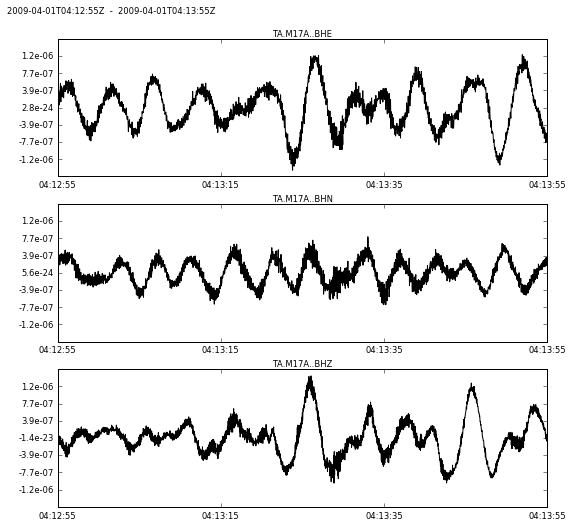

In [8]:
# getStream example
import obspy

## set variables
utc1 = obspy.UTCDateTime('2009-091T04-13-00') - 5
utc2 = utc1 + 60
net = 'TA'
sta = 'M17A'
chan = 'BH?'

## fetch
st = con_fetcher.getStream(utc1, utc2, net, sta, chan)

## plot the boring data
%pylab inline 
st.plot()

The max sta/lta was 3.73 occured at 2009-04-01T01:44:09.950001Z


/home/derrick/anaconda/lib/python2.7/site-packages/obspy/signal/trigger.py:348: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 435 but corresponding boolean dimension is 434
  of.extend(ind2[np.diff(ind2) > 1].tolist())


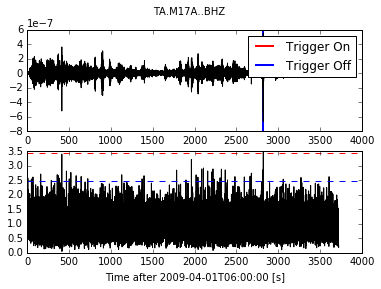

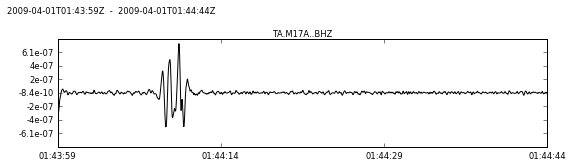

In [9]:
# getConData example

## Read station key and use only TA M17A

stakey = detex.util.readKey('StationKey.csv', key_type='station')
stakey = stakey[stakey.STATION=='M17A']

## Create a generator for fetching continuous data
congen = con_fetcher.getConData(stakey) # note if we dont pass a duration the default is used

## loop over generator and calculate sta/lta values to see if we can find an event
from obspy.signal.trigger import classicSTALTA # for simplicity let's use the basic sta/lta
from obspy.signal.trigger import plotTrigger

sta = 0.5 # short term average in seconds
lta = 2 # long term average in seconds
ratio_max = 0 # int variables to keep track of max and time it occurs
time_max = 0
trace_max = None
cft_max = None

for st in congen: # iterate through the generator until it is exhausted
    trace = st.select(component = 'z')[0] # select vertical component
    trace.filter('bandpass', freqmin=1, freqmax=10, zerophase=True, corners=2) #filter
    sr = trace.stats.sampling_rate # get sampling rate
    starttime = trace.stats.starttime
    cft = classicSTALTA(trace.data, int(sta * sr), int(lta * sr)) # run sta/lta
    cft_max = max(cft) # get max value
    if cft_max > ratio_max: # if the max is greater than old max
        ratio_max = cft_max # set new max
        time_max = starttime + cft.argmax()/float(sr) # set time max
        trace_max = trace.copy()
        cft_max = cft

print("The max sta/lta was %.2f occured at %s" % (ratio_max, time_max))
plotTrigger(trace, cft, ratio_max*.92, ratio_max/1.5)

## Let's get a closer look

st = con_fetcher.getStream(time_max-10, time_max+35, 'TA', 'M17A', 'BHZ')
st.filter('bandpass', freqmin=1, freqmax=5, zerophase=True, corners=2)
st.plot()
        

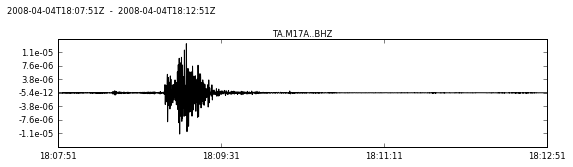

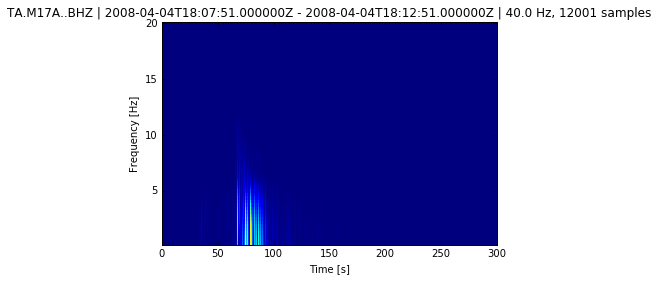

In [10]:
# getConData example

## Create stream generator
evegen = eve_fetcher.getTemData("TemplateKey.csv", "StationKey.csv")
# note: the temkey and stakey parameters can either be paths to csv files or DataFrames

## iterate through each of the known events plot a spectrogram of the one with highest amplitude
amp_max = 0
tr_max = None
for st, evename in evegen:
    trace = st.select(component = 'z')[0]
    trace.detrend('linear')
    trace.filter('bandpass', freqmin=1, freqmax=10, zerophase=True, corners=2)
    z_max = max(trace.data)
    if z_max > amp_max:
        amp_max = z_max
        tr_max = trace.copy()
tr_max.plot()
tr_max.spectrogram()


## DataFetcher with clients
Detex should be able to handle a wide variety of obspy client types, including FDSN, NEIC, EARTHWORM, etc. However, as of version 1.0.4 I have only tested IRIS extensively so using other clients may take a bit of debugging. More tests and bug fixes will follow in future versions. 

### IRIS FDSN client
In order to use the DataFetcher we first need to set up a client object. We will create an FDSN client then initiate an instance of the DataFetcher class and use the getStream function to fetch an obspy stream. 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


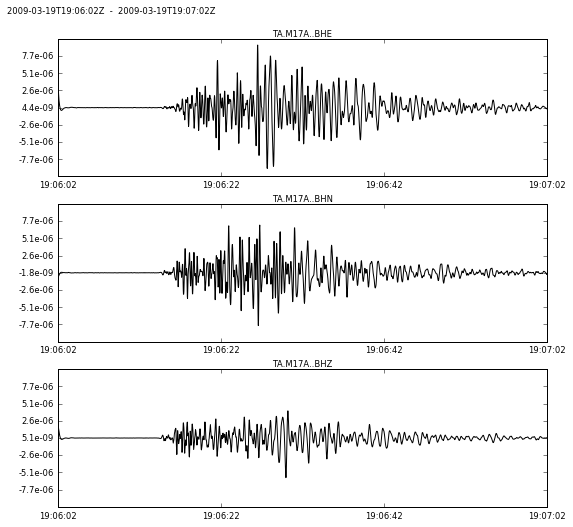

In [11]:
import detex
import obspy
from obspy.fdsn import Client

#setup client
client = Client("IRIS")

# setup fetcher
fetcher = detex.getdata.DataFetcher(method='client', client=client)

# set info
utc1 = obspy.UTCDateTime('2009-03-19T19-06-07') - 5
utc2 = utc1 + 60
net = 'TA'
sta = 'M17A'
chan = 'BH?'

# fetch a stream
st = fetcher.getStream(utc1, utc2, net, sta, chan)

# plot waveforms
%pylab inline 
st.filter('bandpass', freqmin=1, freqmax=10, corners=2, zerophase=True)
st.plot()

If the waveforms look strange it is because this event is actually a blast at a surface coal mine.

The other methods demonstrated in previous sections also work with the DataFetcher attached to IRIS, so I wont illustrate them again here. 

It should be noted that by default the instrument responses have been removed. This can be controlled with the removeResponse input argument which is either set to True or False. 

This should give you all the information you need on how detex gets its data and how to set up a custom DataFetcher to be used by other detex classes. 

# Next Section
The [next section](../Clustering/clustering.md) covers how to perform waveform similarity analysis in preparation for subspace detection. 
